In [185]:
# Uncomment if needed
#!pip install ipympl

In [186]:
from google.colab import output
output.enable_custom_widget_manager()
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import sklearn
print("The scikit-learn version is {}.".format(sklearn.__version__))
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, roc_auc_score
%matplotlib --list
%matplotlib widget
import matplotlib.pyplot as plt
#%matplotlib inline
np.random.seed(1)

The scikit-learn version is 1.0.2.
Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [187]:
df = pd.read_csv(r"titanic_train.csv")
df.info()
df.head(3)
print("Survived: %2.2f%%" % (100.0*df.Survived.sum()/df.Survived.size))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Survived: 38.38%


In [188]:
print(df.Embarked.unique())
emb_max = df[['Survived','Embarked']].groupby(['Embarked']).count().idxmax().values[0]
print("Max embarked at %s" % emb_max)
#df[df.Embarked.isna()] = 'S' #emb_max
df.loc[df.Embarked.isna(), 'Embarked'] = emb_max
df.info()

['S' 'C' 'Q' nan]
Max embarked at S
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [189]:
# Names of male kids contain "Master", so fill the missing Age separateley for them
df.loc[df.Age.isna() & df.Name.str.contains("Master"),'Age'] = 5.0
# Fill missing Age with the median age
median_Age = np.median(df.loc[~df.Age.isna(), 'Age'])
print("Replace missed Age with median Age: %2.1f" % median_Age)
df['Age'].fillna(median_Age, inplace=True)
# Drop insignificant information
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
df.info()

Replace missed Age with median Age: 28.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [190]:
# Now drop duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  776 non-null    int64  
 1   Pclass    776 non-null    int64  
 2   Sex       776 non-null    object 
 3   Age       776 non-null    float64
 4   SibSp     776 non-null    int64  
 5   Parch     776 non-null    int64  
 6   Fare      776 non-null    float64
 7   Embarked  776 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 54.6+ KB


# 4. Преобразуем категориальные признаки с помощью sklearn.preprocessing.OneHotEncoder

In [191]:
#print(OneHotEncoder(drop='if_binary', sparse_output=False).fit_transform(df['Sex'].array.reshape(-1, 1)))
oneHotSexEnc = OneHotEncoder(drop='if_binary', sparse=False)
sex_male = oneHotSexEnc.fit_transform(df['Sex'].array.reshape(-1, 1))

if oneHotSexEnc.categories_[0][1] != "male":
  sex_male = 1-sex_male
  print("Male was encoded as 0, inverted.")
df['Sex_male'] = sex_male

oneHotEmbarkEnc = OneHotEncoder(sparse=False)
embarked = oneHotEmbarkEnc.fit_transform(df['Embarked'].array.reshape(-1, 1))
colNames = ["Embarked_" + item for item in oneHotEmbarkEnc.categories_[0]]
df[colNames] = embarked

In [192]:
df.drop(columns=['Sex', 'Embarked'], inplace=True)
print(df.head(6))

   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_C  \
0         0       3  22.0      1      0   7.2500       1.0         0.0   
1         1       1  38.0      1      0  71.2833       0.0         1.0   
2         1       3  26.0      0      0   7.9250       0.0         0.0   
3         1       1  35.0      1      0  53.1000       0.0         0.0   
4         0       3  35.0      0      0   8.0500       1.0         0.0   
5         0       3  28.0      0      0   8.4583       1.0         0.0   

   Embarked_Q  Embarked_S  
0         0.0         1.0  
1         0.0         0.0  
2         0.0         1.0  
3         0.0         1.0  
4         0.0         1.0  
5         1.0         0.0  


#3. Разделяем выборку на train и test.

In [193]:
y = df.Survived
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns=['Survived']), y, stratify=y, test_size=0.15)
print("Validation set size = %d" % y_val.size)
print("Survived on validation set: %2.2f%%" % (100.0*y_val.sum()/y_val.size))

Validation set size = 117
Survived on validation set: 41.03%


#4. ... а некатегориальные с помощью sklearn.preprocessing.StandardScaler

In [194]:
# Train the scaler only on X_train, then transform both, X_train and X_val
to_scale = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
scaler = StandardScaler()
scaler.fit(X_train[to_scale])
X_train[to_scale] = scaler.transform(X_train[to_scale])
X_val[to_scale] = scaler.transform(X_val[to_scale])

# Обучение модели логистической регрессии

In [195]:
# Fixing random_state here, so that the RandomizedSearchCV would optimize later for hyperparameters, not the random seed.
lr =  LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)


LogisticRegression(random_state=1)

# расчёт всех метрик классификации, которые были упомянуты на занятии
Не считаю MSE, MAE и R2, так как это метрики для регрессии, а не классификации


In [196]:
predicted_train = lr.predict(X_train)
predicted_val = lr.predict(X_val)
(lr_train_acc, lr_val_acc) = (100*accuracy_score(y_train, predicted_train), 100*accuracy_score(y_val, predicted_val))
(lr_train_f1, lr_val_f1) = (100*f1_score(y_train, predicted_train), 100*f1_score(y_val, predicted_val))
(lr_train_auc, lr_val_auc) = (100*roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1]), 100*roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]))
print("          Train | Test")  
print("Accuracy:  %2.1f | %2.1f" % (lr_train_acc, lr_val_acc))  
print("F1:        %2.1f | %2.1f" % (lr_train_f1, lr_val_f1))     
print("ROC_AUC:   %2.1f | %2.1f" % (lr_train_auc, lr_val_auc))  

          Train | Test
Accuracy:  78.0 | 78.6
F1:        72.5 | 74.2
ROC_AUC:   84.8 | 84.0


# и KNN

In [197]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_result = knn.fit(X_train, y_train)

# расчёт всех метрик классификации, которые были упомянуты на занятии
Не считаю MSE, MAE и R2, так как это метрики для регрессии, а не классификации

In [198]:
predicted_train = knn.predict(X_train)
predicted_val = knn.predict(X_val)

(knn_train_acc, knn_val_acc) = (100*accuracy_score(y_train, predicted_train), 100*accuracy_score(y_val, predicted_val))
(knn_train_f1, knn_val_f1) = (100*f1_score(y_train, predicted_train), 100*f1_score(y_val, predicted_val))
(knn_train_auc, knn_val_auc) = (100*roc_auc_score(y_train, knn.predict_proba(X_train)[:, 1]), 100*roc_auc_score(y_val, knn.predict_proba(X_val)[:, 1]))
print("          Train | Test")  
print("Accuracy:  %2.1f | %2.1f" % (knn_train_acc, knn_val_acc))  
print("F1:        %2.1f | %2.1f" % (knn_train_f1, knn_val_f1))     
print("ROC_AUC:   %2.1f | %2.1f" % (knn_train_auc, knn_val_auc))  


          Train | Test
Accuracy:  83.9 | 76.9
F1:        79.8 | 72.7
ROC_AUC:   91.7 | 78.5


# Выводы.
kNN "переобучается", об этом свидетельствует снижение всех метрик на валидационной выборке. Это логично, так как kNN просто полностью запоминает обучающую выборку. Но даже на обучающей выборке точность меньше 100%, значит, в выбранном пространстве признаков данные плохо разделимы. Посмотрю ещё в конце, как кластеризуются данные с помощью t-SNE.

# 6. Подбор гиперпараметров для обоих моделей с помощью RandomizedSearchCV

In [199]:
params_lr = dict(
    max_iter = range(100, 251, 30),
    penalty = ['l1', 'l2', 'elasticnet'],
    l1_ratio = [0.5, 0.7],
    tol = [5e-5, 7e-5, 1e-4, 15e-5, 2e-4],
    C = [0.05, 0.1, 0.2, 0.5, 0.7, 1],
    solver = ['liblinear', 'saga']
)
lr_cv = RandomizedSearchCV(lr, params_lr, n_jobs=-1, cv=4, n_iter=250)
lr_cv.fit(X_train, y_train)
print(lr_cv.best_params_)

{'tol': 7e-05, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'l1_ratio': 0.7, 'C': 0.1}


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
148 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
148 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 457, in _check_solver
    raise ValueError(
ValueError: Only

In [200]:
predicted_train = lr_cv.predict(X_train)
predicted_val = lr_cv.predict(X_val)

(lrcv_train_acc, lrcv_val_acc) = (100*accuracy_score(y_train, predicted_train), 100*accuracy_score(y_val, predicted_val))
(lrcv_train_f1, lrcv_val_f1) = (100*f1_score(y_train, predicted_train), 100*f1_score(y_val, predicted_val))
(lrcv_train_auc, lrcv_val_auc) = (100*roc_auc_score(y_train, lr_cv.predict_proba(X_train)[:, 1]), 100*roc_auc_score(y_val, lr_cv.predict_proba(X_val)[:, 1]))
print("          Train | Test")  
print("Accuracy:  %2.1f | %2.1f" % (lrcv_train_acc, lrcv_val_acc))  
print("F1:        %2.1f | %2.1f" % (lrcv_train_f1, lrcv_val_f1))     
print("ROC_AUC:   %2.1f | %2.1f" % (lrcv_train_auc, lrcv_val_auc))  

          Train | Test
Accuracy:  77.7 | 81.2
F1:        71.2 | 76.6
ROC_AUC:   84.4 | 85.3


In [201]:
params_knn = dict(
    n_neighbors = range(1, 12),
    weights = ['uniform', 'distance'],
    p = np.arange(1, 3, 0.5)
)
knn_cv = RandomizedSearchCV(knn, params_knn, n_jobs=-1, cv=4, n_iter=50)
knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)

{'weights': 'uniform', 'p': 1.5, 'n_neighbors': 10}


In [202]:
predicted_train = knn_cv.predict(X_train)
predicted_val = knn_cv.predict(X_val)

(knncv_train_acc, knncv_val_acc) = (100*accuracy_score(y_train, predicted_train), 100*accuracy_score(y_val, predicted_val))
(knncv_train_f1, knncv_val_f1) = (100*f1_score(y_train, predicted_train), 100*f1_score(y_val, predicted_val))
(knncv_train_auc, knncv_val_auc) = (100*roc_auc_score(y_train, knn_cv.predict_proba(X_train)[:, 1]), 100*roc_auc_score(y_val, knn_cv.predict_proba(X_val)[:, 1]))
print("          Train | Test")  
print("Accuracy:  %2.1f | %2.1f" % (knncv_train_acc, knncv_val_acc))  
print("F1:        %2.1f | %2.1f" % (knncv_train_f1, knncv_val_f1))     
print("ROC_AUC:   %2.1f | %2.1f" % (knncv_train_auc, knncv_val_auc))  

          Train | Test
Accuracy:  80.7 | 78.6
F1:        73.6 | 72.5
ROC_AUC:   89.5 | 79.8


#напишите, почему, как вы думаете, эти параметры подошли.
Эти параметры подошли, т.к. их подобрали с помощью кросс-валидации.
После тюнинга гиперпараметров метрики качества обоих моделей на обучающей выборке снизились, а на валидационной - немного выросли. Это говорит о том, что мы подобрали гиперпараметры, при которых снижается переобучение классификаторов.

In [203]:
print("Logistic Regression metrics gain:")
print("          Train | Test")  
print("Accuracy:  %+2.1f | %2.1f" % (lrcv_train_acc-lr_train_acc, lrcv_val_acc-lr_val_acc))  
print("F1:        %+2.1f | %2.1f" % (lrcv_train_f1-lr_train_f1, lrcv_val_f1-lr_val_f1))     
print("ROC_AUC:   %+2.1f | %2.1f" % (lrcv_train_auc-lr_train_auc, lrcv_val_auc-lr_val_auc))
print()
print("k-NN metrics gain:")
print("          Train | Test")  
print("Accuracy:  %+2.1f | %2.1f" % (knncv_train_acc-knn_train_acc, knncv_val_acc-knn_val_acc))  
print("F1:        %+2.1f | %2.1f" % (knncv_train_f1-knn_train_f1, knncv_val_f1-knn_val_f1))     
print("ROC_AUC:   %+2.1f | %2.1f" % (knncv_train_auc-knn_train_auc, knncv_val_auc-knn_val_auc))  

Logistic Regression metrics gain:
          Train | Test
Accuracy:  -0.3 | 2.6
F1:        -1.3 | 2.4
ROC_AUC:   -0.4 | 1.3

k-NN metrics gain:
          Train | Test
Accuracy:  -3.2 | 1.7
F1:        -6.2 | -0.2
ROC_AUC:   -2.2 | 1.3


# Bonus: t-SNE

In [204]:
if 'index' not in df.columns:
  df.reset_index(inplace = True)

X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(df.drop(columns=['index','Survived']))
#X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(df.drop(columns=['index']))



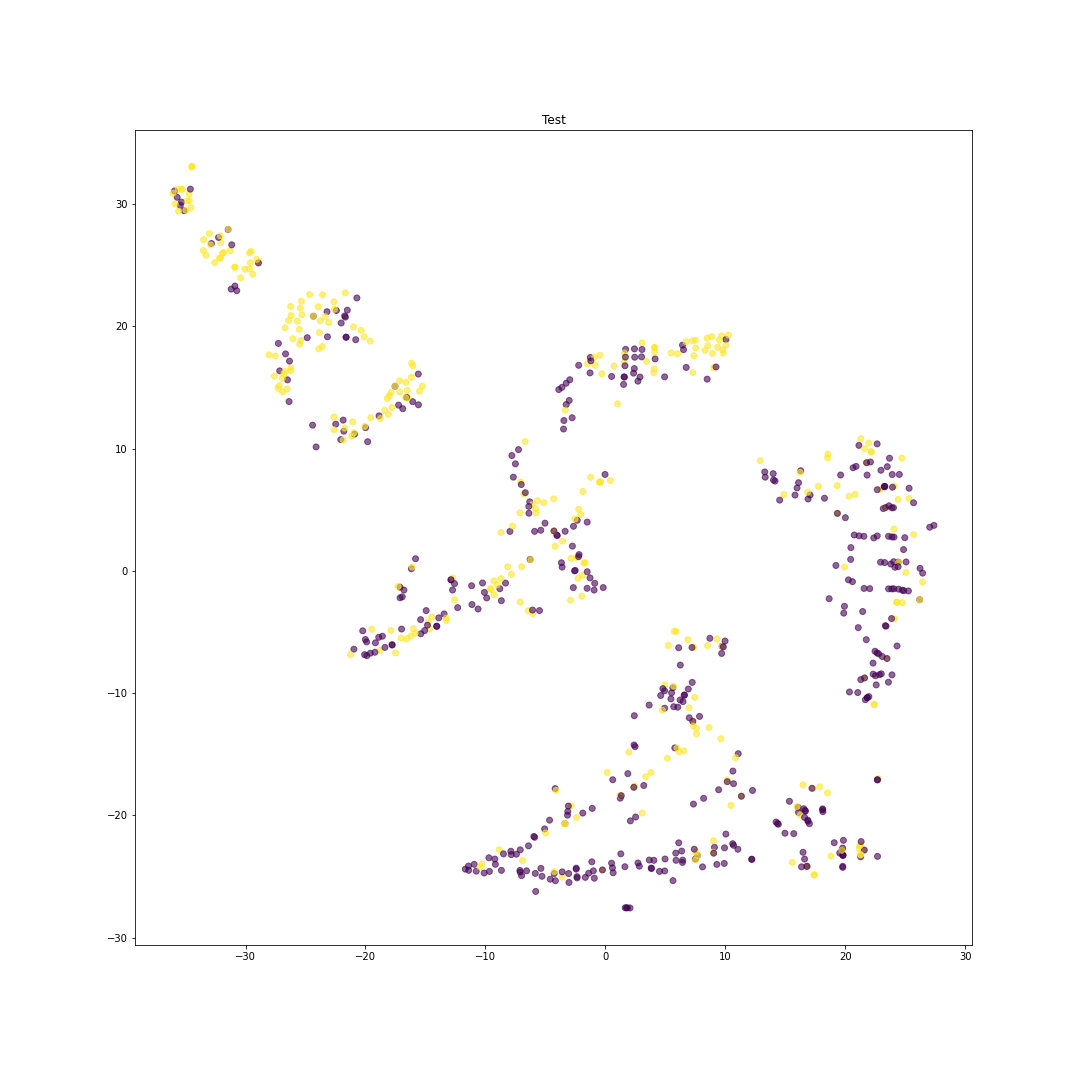

In [205]:
def onpick1(event):
  (fstr, ftup) = ("", ())
  for idx in event.ind:
    #print(idx)
    fstr = fstr + "idx %d: Age: %2.2f, Fare: %2.2f\n"
    ftup = ftup + (idx, df.Age[idx].item(), df.Fare[idx].item())
  ax.set_title(fstr % ftup)

fig, ax = plt.subplots()
fig.canvas.mpl_connect('pick_event', onpick1)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = df.Survived, alpha=0.6, picker=True)
ax.set_title("Test")
plt.show()
plt.rcParams["figure.figsize"] = (15,15)


По t-SNE видно, что во многих кластерах присутствуют как выжившие, так и погибшие. Это говорит о том, что выбранных признаков недостаточно для линейного разделения классов.